# Full GAN

In [1]:
import librosa
import io
import os
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import Audio

import torch
import torch.nn as nn
import torch.optim as optim

import librosa
import librosa.display
import IPython.display as ipd
import soundfile as sf

import torch
import torch.nn as nn
import torch.optim as optim
import librosa
import librosa.display
import numpy as np
import matplotlib.pyplot as plt
import pickle

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
# Use CUDA if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [4]:
path_models = '/content/gdrive/MyDrive/project_mml/models'
path_music = '/content/gdrive/MyDrive/project_mml/examples'
file_path = "/content/gdrive/MyDrive/project_mml/data/global_stft_stats.pkl"

# Open and load the .pkl file
with open(file_path, 'rb') as file:
    stft_stats = pickle.load(file)

stft_stats

{'magnitude_mean': 0.78685814,
 'magnitude_std': 4.0197673,
 'phase_mean': 0.008972294,
 'phase_std': 1.8158828}

In [5]:
# Abrimos datos preprocesados para el modelo
stft_dataset = torch.load('/content/gdrive/MyDrive/project_mml/data/stft_dataset.pt')
print(stft_dataset)

In [6]:
# Training parameters
batch_size = 16
num_epochs = 2

# Parámetros de STFT y audio
n_fft = 1024
hop_length = 512
sr = 44100  # Frecuencia de muestreo

# Create DataLoader
stft_loader = torch.utils.data.DataLoader(stft_dataset, batch_size=batch_size, shuffle=True)

In [15]:
num_epochs = 10

def save_model(model, epoch, path):
    torch.save({
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
    }, path)

class Generator(nn.Module):
    def __init__(self, noise_dim, output_channels):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.ConvTranspose2d(noise_dim, 1024, kernel_size=(4, 4), stride=(1, 1), padding=0),
            nn.BatchNorm2d(1024),
            nn.ReLU(True),
            nn.ConvTranspose2d(1024, 512, kernel_size=(4, 4), stride=(2, 2), padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(True),
            nn.ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(True),
            nn.ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            nn.ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 4), padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            nn.ConvTranspose2d(64, 32, kernel_size=(4, 4), stride=(2, 4), padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(True),
            nn.ConvTranspose2d(32, output_channels, kernel_size=(6, 81), stride=(4, 5), padding=(1, 3), output_padding=(1, 2)),
            nn.Tanh()
        )

    def forward(self, x):
        return self.model(x)

class Discriminator(nn.Module):
    def __init__(self, input_channels):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(input_channels, 64, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(256, 1, kernel_size=4, stride=1, padding=0),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x)

# Initialize models
latent_dim = 100
generator = Generator(latent_dim, 2).to(device)  # Outputs for magnitude and phase
discriminator = Discriminator(2).to(device)  # Inputs for magnitude and phase

# Learning Rate
lr_d = 10e-5
lr_g = 10e-4

# Optimizers
optimizerG = optim.Adam(generator.parameters(), lr=lr_g, betas=(0.5, 0.999))
optimizerD = optim.Adam(discriminator.parameters(), lr=lr_d, betas=(0.5, 0.999))

# Loss function
criterion = nn.BCELoss()

# losses
d_losses = []
g_losses = []

# Set initial values
best_g_loss = float('inf')

for epoch in range(num_epochs):
    for (real_stfts,) in stft_loader:
        real_stfts = real_stfts.to(device)
        batch_size = real_stfts.size(0)

        # Create real and fake labels
        real_labels = torch.ones(batch_size, 1).to(device)
        fake_labels = torch.zeros(batch_size, 1).to(device)

        # Train the discriminator
        optimizerD.zero_grad()
        outputs = discriminator(real_stfts)
        real_labels_resized = torch.ones_like(outputs)  # Resize real labels to match discriminator output
        d_loss_real = criterion(outputs, real_labels_resized)

        noise = torch.randn(batch_size, latent_dim, 1, 1).to(device)
        fake_stfts = generator(noise)
        outputs = discriminator(fake_stfts.detach())
        fake_labels_resized = torch.zeros_like(outputs)  # Resize fake labels to match discriminator output
        d_loss_fake = criterion(outputs, fake_labels_resized)

        d_loss = d_loss_real + d_loss_fake
        d_loss.backward()
        optimizerD.step()

        # Train the generator
        optimizerG.zero_grad()
        outputs = discriminator(fake_stfts)
        real_labels_resized = torch.ones_like(outputs)  # Resize real labels to match discriminator output
        g_loss = criterion(outputs, real_labels_resized)
        g_loss.backward()
        optimizerG.step()

    d_losses.append(d_loss.item())
    g_losses.append(g_loss.item())

    print(f'Epoch [{epoch+1}/{num_epochs}], d_loss: {d_loss.item():.4f}, g_loss: {g_loss.item():.4f}')

    # Guardar el mejor modelo
    if g_loss.item() < best_g_loss:
        best_g_loss = g_loss.item()
        save_model(generator, epoch+1, os.path.join(path_models, f'best_generator.pth'))
        save_model(discriminator, epoch+1, os.path.join(path_models, f'best_discriminator.pth'))

    # Guardar checkpoints de modelos
    if (epoch + 1) % 50 == 0:
        save_model(generator, epoch+1, os.path.join(path_models, f'generator_epoch_{epoch+1}.pth'))
        save_model(discriminator, epoch+1, os.path.join(path_models, f'discriminator_epoch_{epoch+1}.pth'))

Epoch [1/10], d_loss: 0.9789, g_loss: 1.0100
Epoch [2/10], d_loss: 0.4056, g_loss: 1.9791
Epoch [3/10], d_loss: 0.2811, g_loss: 2.2424
Epoch [4/10], d_loss: 0.2276, g_loss: 2.6927
Epoch [5/10], d_loss: 0.1200, g_loss: 3.0626
Epoch [6/10], d_loss: 0.0681, g_loss: 3.7115
Epoch [7/10], d_loss: 0.0662, g_loss: 3.9804
Epoch [8/10], d_loss: 0.0448, g_loss: 4.2705
Epoch [9/10], d_loss: 0.0292, g_loss: 5.2423
Epoch [10/10], d_loss: 0.0261, g_loss: 4.5316


In [9]:
print(f"real_stfts.shape: {real_stfts.shape}")
print(f"real_labels.shape: {real_labels.shape}")
print(f"fake_stfts.shape: {fake_stfts.shape}")
print(f"fake_labels.shape: {fake_labels.shape}")

real_stfts.shape: torch.Size([12, 2, 513, 2582])


NameError: name 'real_labels' is not defined

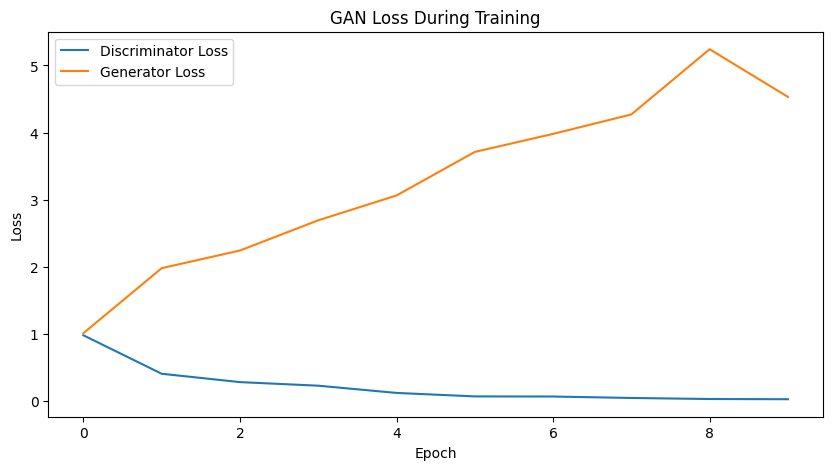

In [16]:
# Graficar las pérdidas
plt.figure(figsize=(10, 5))
plt.plot(d_losses, label='Discriminator Loss')
plt.plot(g_losses, label='Generator Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('GAN Loss During Training')
plt.show()

In [17]:
n_fft = 1024
hop_length = 512
sr = 44100  # Sampling rate

for i in range(10):
  # Generate new magnitudes and phases
  noise = torch.randn(1, latent_dim, 1, 1).to(device)
  generated_stft = generator(noise).detach().cpu().numpy()
  generated_magnitude = generated_stft[:, 0, :, :]
  generated_phase = generated_stft[:, 1, :, :]

  # Denormalize
  generated_magnitude = (generated_magnitude * stft_stats['magnitude_std']) + stft_stats['magnitude_mean']
  generated_phase = (generated_phase * stft_stats['phase_std']) + stft_stats['phase_mean']

  # Combine magnitude and phase to obtain the STFT
  generated_stft = generated_magnitude * np.exp(1j * generated_phase)

  # Convert to audio signal
  generated_audio = librosa.istft(generated_stft[0], hop_length=hop_length, win_length=n_fft)

  # Ensure the audio signal has the correct shape
  if generated_audio.ndim > 1:
      generated_audio = np.squeeze(generated_audio)

  # Ensure the audio signal is in the correct format
  generated_audio = generated_audio.astype(np.float32)

  # Save the generated audio
  sf.write(f'{path_music}/generated_audio_gan_{i+1}.wav', generated_audio, samplerate=sr)

  # Play the generated audio
  ipd.Audio(f'{path_music}/generated_audio_gan_{i+1}.wav')

In [18]:
n_fft = 1024
hop_length = 512
sr = 44100  # Sampling rate

# Generate new magnitudes and phases
noise = torch.randn(1, latent_dim, 1, 1).to(device)
generated_stft = generator(noise).detach().cpu().numpy()
generated_magnitude = generated_stft[:, 0, :, :]
generated_phase = generated_stft[:, 1, :, :]

# Denormalize
generated_magnitude = (generated_magnitude * stft_stats['magnitude_std']) + stft_stats['magnitude_mean']
generated_phase = (generated_phase * stft_stats['phase_std']) + stft_stats['phase_mean']

# Combine magnitude and phase to obtain the STFT
generated_stft = generated_magnitude * np.exp(1j * generated_phase)

# Convert to audio signal
generated_audio = librosa.istft(generated_stft[0], hop_length=hop_length, win_length=n_fft)

# Ensure the audio signal has the correct shape
if generated_audio.ndim > 1:
    generated_audio = np.squeeze(generated_audio)

# Ensure the audio signal is in the correct format
generated_audio = generated_audio.astype(np.float32)

# Save the generated audio
sf.write('generated_audio.wav', generated_audio, samplerate=sr)

# Play the generated audio
ipd.Audio('generated_audio.wav')

In [29]:
torch.cuda.empty_cache()

In [8]:
import torch
import torch.nn as nn
import torch.optim as optim
import os

# Number of epochs and gradient accumulation steps
num_epochs = 10
accumulation_steps = 4  # Number of steps to accumulate gradients

def save_model(model, epoch, path):
    torch.save({
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
    }, path)

class Generator(nn.Module):
    def __init__(self, noise_dim, output_channels):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.ConvTranspose2d(noise_dim, 1024, kernel_size=(4, 4), stride=(1, 1), padding=0),
            nn.BatchNorm2d(1024),
            nn.ReLU(True),
            nn.ConvTranspose2d(1024, 512, kernel_size=(4, 4), stride=(2, 2), padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(True),
            nn.ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(True),
            nn.ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            nn.ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 4), padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            nn.ConvTranspose2d(64, 32, kernel_size=(4, 4), stride=(2, 4), padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(True),
            nn.ConvTranspose2d(32, output_channels, kernel_size=(6, 81), stride=(4, 5), padding=(1, 3), output_padding=(1, 2)),
            nn.Tanh()
        )

    def forward(self, x):
        return self.model(x)

class Discriminator(nn.Module):
    def __init__(self, input_channels):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(input_channels, 64, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=0)
        )

    def forward(self, x):
        return self.model(x)

# Initialize models
latent_dim = 100
generator = Generator(latent_dim, 2).to(device)  # Outputs for magnitude and phase
discriminator = Discriminator(2).to(device)  # Inputs for magnitude and phase

# Learning Rate
lr_d = 1e-4
lr_g = 1e-4

# Optimizers
optimizerG = optim.Adam(generator.parameters(), lr=lr_g, betas=(0.5, 0.999))
optimizerD = optim.Adam(discriminator.parameters(), lr=lr_d, betas=(0.5, 0.999))

# WGAN-GP parameters
lambda_gp = 10
critic_iter = 5  # Number of discriminator updates per generator update

# Function to compute gradient penalty
def compute_gradient_penalty(D, real_samples, fake_samples):
    alpha = torch.rand(real_samples.size(0), 1, 1, 1, device=real_samples.device)
    interpolates = (alpha * real_samples + ((1 - alpha) * fake_samples)).requires_grad_(True)
    d_interpolates = D(interpolates)
    fake = torch.ones(d_interpolates.size(), device=real_samples.device)
    gradients = torch.autograd.grad(
        outputs=d_interpolates,
        inputs=interpolates,
        grad_outputs=fake,
        create_graph=True,
        retain_graph=True,
        only_inputs=True,
    )[0]
    gradients = gradients.view(gradients.size(0), -1)
    gradient_penalty = ((gradients.norm(2, dim=1) - 1) ** 2).mean()
    return gradient_penalty

# Training Loop
d_losses = []
g_losses = []

# Set initial values
best_g_loss = float('inf')

for epoch in range(num_epochs):
    for i, (real_stfts,) in enumerate(stft_loader):
        real_stfts = real_stfts.to(device)
        batch_size = real_stfts.size(0)

        # Train Discriminator
        optimizerD.zero_grad()

        # Real loss
        real_validity = discriminator(real_stfts)
        d_loss_real = -torch.mean(real_validity)

        # Fake loss
        noise = torch.randn(batch_size, latent_dim, 1, 1, device=device)
        fake_stfts = generator(noise)
        fake_validity = discriminator(fake_stfts.detach())
        d_loss_fake = torch.mean(fake_validity)

        # Gradient penalty
        gradient_penalty = compute_gradient_penalty(discriminator, real_stfts.data, fake_stfts.data)

        d_loss = (d_loss_real + d_loss_fake + lambda_gp * gradient_penalty) / accumulation_steps
        d_loss.backward()

        if (i + 1) % accumulation_steps == 0:
            optimizerD.step()
            optimizerD.zero_grad()

        # Train the generator every critic_iter iterations
        if i % critic_iter == 0:
            optimizerG.zero_grad()
            fake_stfts = generator(noise)
            fake_validity = discriminator(fake_stfts)
            g_loss = -torch.mean(fake_validity) / accumulation_steps
            g_loss.backward()

            if (i + 1) % accumulation_steps == 0:
                optimizerG.step()
                optimizerG.zero_grad()

    d_losses.append(d_loss.item())
    g_losses.append(g_loss.item())

    print(f'Epoch [{epoch+1}/{num_epochs}], d_loss: {d_loss.item():.4f}, g_loss: {g_loss.item():.4f}')

    # Save the best model
    if g_loss.item() < best_g_loss:
        best_g_loss = g_loss.item()
        save_model(generator, epoch+1, os.path.join(path_models, f'best_generator.pth'))
        save_model(discriminator, epoch+1, os.path.join(path_models, f'best_discriminator.pth'))

    # Save model checkpoints every 50 epochs
    if (epoch + 1) % 50 == 0:
        save_model(generator, epoch+1, os.path.join(path_models, f'generator_epoch_{epoch+1}.pth'))
        save_model(discriminator, epoch+1, os.path.join(path_models, f'discriminator_epoch_{epoch+1}.pth'))

Epoch [1/10], d_loss: 89.6694, g_loss: -0.0158
Epoch [2/10], d_loss: 8.6597, g_loss: -0.0236
Epoch [3/10], d_loss: 4.4467, g_loss: -0.0292
Epoch [4/10], d_loss: 4.6310, g_loss: -0.0420
Epoch [5/10], d_loss: 1.0338, g_loss: -0.0509
Epoch [6/10], d_loss: 0.5789, g_loss: -0.0564
Epoch [7/10], d_loss: 1.8189, g_loss: -0.0642
Epoch [8/10], d_loss: 2.1837, g_loss: -0.0706
Epoch [9/10], d_loss: 0.8717, g_loss: -0.0761
Epoch [10/10], d_loss: 1.0020, g_loss: -0.0809


In [7]:
import torch
import torch.nn as nn
import torch.optim as optim
import os
import gc

# Number of epochs and gradient accumulation steps
num_epochs = 10
accumulation_steps = 4  # Number of steps to accumulate gradients

def save_model(model, epoch, path):
    torch.save({
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
    }, path)

class Generator(nn.Module):
    def __init__(self, noise_dim, output_channels):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.ConvTranspose2d(noise_dim, 1024, kernel_size=(4, 4), stride=(1, 1), padding=0),
            nn.BatchNorm2d(1024),
            nn.ReLU(True),
            nn.ConvTranspose2d(1024, 512, kernel_size=(4, 4), stride=(2, 2), padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(True),
            nn.ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(True),
            nn.ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            nn.ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 4), padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            nn.ConvTranspose2d(64, 32, kernel_size=(4, 4), stride=(2, 4), padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(True),
            nn.ConvTranspose2d(32, output_channels, kernel_size=(6, 81), stride=(4, 5), padding=(1, 3), output_padding=(1, 2)),
            nn.Tanh()
        )

    def forward(self, x):
        return self.model(x)

class Discriminator(nn.Module):
    def __init__(self, input_channels):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(input_channels, 64, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=0)
        )

    def forward(self, x):
        return self.model(x)

# Initialize models
latent_dim = 100
generator = Generator(latent_dim, 2).to(device)  # Outputs for magnitude and phase
discriminator = Discriminator(2).to(device)  # Inputs for magnitude and phase

# Learning Rate
lr_d = 1e-4
lr_g = 1e-4

# Optimizers
optimizerG = optim.Adam(generator.parameters(), lr=lr_g, betas=(0.5, 0.999))
optimizerD = optim.Adam(discriminator.parameters(), lr=lr_d, betas=(0.5, 0.999))

# WGAN-GP parameters
lambda_gp = 10
critic_iter = 5  # Number of discriminator updates per generator update

# Function to compute gradient penalty
def compute_gradient_penalty(D, real_samples, fake_samples):
    alpha = torch.rand(real_samples.size(0), 1, 1, 1, device=real_samples.device)
    interpolates = (alpha * real_samples + ((1 - alpha) * fake_samples)).requires_grad_(True)
    d_interpolates = D(interpolates)
    fake = torch.ones(d_interpolates.size(), device=real_samples.device)
    gradients = torch.autograd.grad(
        outputs=d_interpolates,
        inputs=interpolates,
        grad_outputs=fake,
        create_graph=True,
        retain_graph=True,
        only_inputs=True,
    )[0]
    gradients = gradients.view(gradients.size(0), -1)
    gradient_penalty = ((gradients.norm(2, dim=1) - 1) ** 2).mean()
    return gradient_penalty

# Training Loop
d_losses = []
g_losses = []

for epoch in range(num_epochs):
    for i, (real_stfts,) in enumerate(stft_loader):
        real_stfts = real_stfts.to(device)
        batch_size = real_stfts.size(0)

        # Train Discriminator
        optimizerD.zero_grad()

        # Real loss
        real_validity = discriminator(real_stfts)
        d_loss_real = -torch.mean(real_validity)

        # Fake loss
        noise = torch.randn(batch_size, latent_dim, 1, 1, device=device)
        fake_stfts = generator(noise)
        fake_validity = discriminator(fake_stfts.detach())
        d_loss_fake = torch.mean(fake_validity)

        # Gradient penalty
        gradient_penalty = compute_gradient_penalty(discriminator, real_stfts.data, fake_stfts.data)

        d_loss = (d_loss_real + d_loss_fake + lambda_gp * gradient_penalty) / accumulation_steps
        d_loss.backward()

        if (i + 1) % accumulation_steps == 0:
            optimizerD.step()
            optimizerD.zero_grad()

        # Train the generator every critic_iter iterations
        if i % critic_iter == 0:
            optimizerG.zero_grad()
            fake_stfts = generator(noise)
            fake_validity = discriminator(fake_stfts)
            g_loss = -torch.mean(fake_validity) / accumulation_steps
            g_loss.backward()

            if (i + 1) % accumulation_steps == 0:
                optimizerG.step()
                optimizerG.zero_grad()

    d_losses.append(d_loss.item())
    g_losses.append(g_loss.item())

    print(f'Epoch [{epoch+1}/{num_epochs}], d_loss: {d_loss.item():.4f}, g_loss: {g_loss.item():.4f}')

    # Save the best model
    if g_loss.item() < best_g_loss:
        best_g_loss = g_loss.item()
        save_model(generator, epoch+1, os.path.join(path_models, f'best_generator.pth'))
        save_model(discriminator, epoch+1, os.path.join(path_models, f'best_discriminator.pth'))

    # Save model checkpoints every 50 epochs
    if (epoch + 1) % 50 == 0:
        save_model(generator, epoch+1, os.path.join(path_models, f'generator_epoch_{epoch+1}.pth'))
        save_model(discriminator, epoch+1, os.path.join(path_models, f'discriminator_epoch_{epoch+1}.pth'))

    # Clear GPU cache and collect garbage
    torch.cuda.empty_cache()
    gc.collect()

Epoch [1/10], d_loss: 45.4421, g_loss: 0.0034


NameError: name 'best_g_loss' is not defined

In [16]:
import torch
import gc

# Function to clear GPU memory
def clear_gpu_memory():
    # Delete variables
    variables = [var for var in globals() if isinstance(globals()[var], torch.Tensor)]
    for var in variables:
        del globals()[var]

    # Call garbage collector
    gc.collect()

    # Empty the cache
    torch.cuda.empty_cache()
    print("GPU memory cleared.")

# Simulate memory usage
x = torch.randn(100000000, device='cuda')
y = torch.randn(100000000, device='cuda')

# Clear GPU memory
clear_gpu_memory()

# Verify memory is cleared
torch.cuda.memory_summary(device=None, abbreviated=False)

OutOfMemoryError: CUDA out of memory. Tried to allocate 382.00 MiB. GPU 

In [26]:
# Clear GPU memory
clear_gpu_memory()

GPU memory cleared.
